<a href="https://colab.research.google.com/github/LeeYuuuan/Applied_AI_midterm_exam/blob/main/data_precessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonfflynn","key":"620de0050762552556db28d497951638"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats
! unzip dogs-vs-cats.zip
# ! unzip train.zip > /dev/null

100% 811M/812M [00:36<00:00, 24.4MB/s]
100% 812M/812M [00:37<00:00, 23.0MB/s]
Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
# ! rm -rf train.zip
! rm -rf sampleSubmission.csv
! rm -rf test1.zip
! rm -rf dogs-vs-cats.zip

In [ ]:
from PIL import Image
import io
import zipfile

import numpy as np
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns




In [ ]:
torch.random.manual_seed(42)
np.random.seed(42)

In [ ]:
label_str = ['cat', 'dog']

## data preprocessing

In [ ]:
def preprocess(input_zip, size=(128, 128)):
    images_processed = []

    with zipfile.ZipFile(input_zip, 'r') as archive_zip:
        archives = archive_zip.namelist()
        images = []
        labels = []
        for i, archive in enumerate(archives):
            if archive.endswith(('.png', '.jpg', '.jpeg')):
                images.append(archive)
                if 'cat' in archive:
                    labels.append(0)
                if 'dog' in archive:
                    labels.append(1)
        # images = [archive for archive in archives if archive.endswith(('.png', '.jpg', '.jpeg'))]
        imgs = []
        for img_path in tqdm(images):
            with archive_zip.open(img_path) as image_zip:
                img = Image.open(io.BytesIO(image_zip.read()))


                imgs.append(img)
                # images_processed.append(img_array)

    # dataset = np.array(images_processed)

    return imgs, np.array(labels)

In [ ]:
class Cat_dog_dataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.images = cat_and_dog_images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
cat_and_dog_images, labels = preprocess('train.zip')

100%|██████████| 25000/25000 [00:05<00:00, 4559.68it/s]


In [ ]:
cat_dog_dataset = Cat_dog_dataset(transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

]))

In [ ]:
def show_trainsform_and_original(cat_and_dog_images, data_samples):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for idx in range(5):
        if idx > 2:
            i = 12500 + idx
        else:
            i = idx
        image_transform, label_transform = cat_dog_dataset[i]
        # Convert tensor image to numpy array for display
        image_transform_np = image_transform.permute(1, 2, 0).numpy()
        image_original = data_samples[i]

        # Reverse the normalization for display
        image_transform_np = (image_transform_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])


        image_transform_np = np.clip(image_transform_np, 0, 1)


        axes[0, idx].imshow(image_transform_np)
        axes[0, idx].set_title(f"Transformed - {label_str[label_transform]}")

        axes[1, idx].imshow(image_original)
        axes[1, idx].set_title(f"Original - {label_str[label_transform]}")

        for ax in axes.flat:
            ax.axis('off')



    plt.tight_layout()
    plt.show()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/figures/transformed_and_original.png')


## demonstrate some of the transformed samples

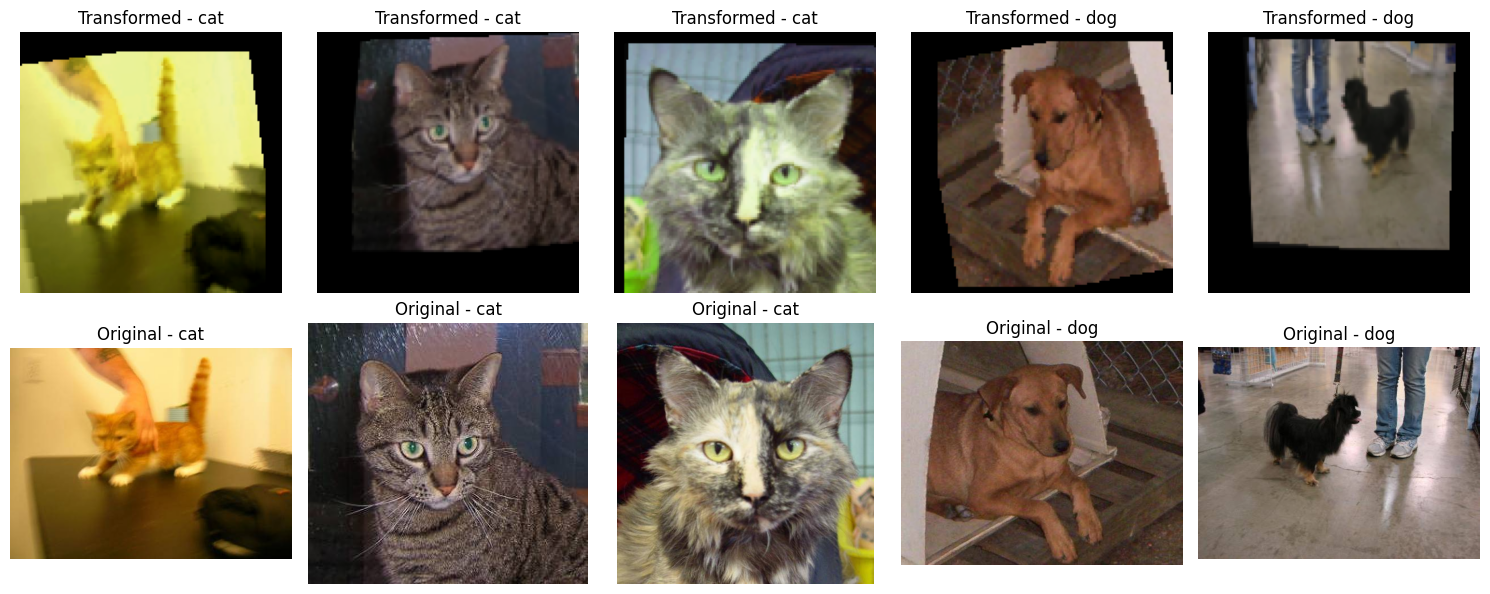

<Figure size 640x480 with 0 Axes>

In [ ]:
show_trainsform_and_original(cat_dog_dataset, cat_and_dog_images)

## split dataset into train/test (7:3)

In [ ]:
train_dataset, test_dataset = train_test_split(cat_dog_dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
del cat_dog_dataset, labels, cat_and_dog_images

## train classifier A

In [ ]:
def plot_loss(losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/figures/loss.png')
    plt.show()

In [ ]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=150):
    losses = []
    test_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=f'{loss.item():.4f}')
                pbar.update()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss/len(test_loader))
        losses.append(running_loss/len(train_loader))

        tqdm.write(f'Train Loss: {running_loss/len(train_loader):.4f} | 'f'Test Loss: {test_loss/len(test_loader):.4f}')



        if (epoch + 1) % 20 == 0:
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/model/classifier_A_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Applied_AI_Course_Assignment/Midterm/model/classifier_A_end.pth')
    return losses, test_losses



### the first training
- unfreeze fc, layer4, layer3
- 50 epochs will lead to model overfitting

In [ ]:
classifier_A = models.resnet18(pretrained=True)
for param in classifier_A.parameters():
    param.requires_grad = False

for param in classifier_A.fc.parameters():
    param.requires_grad = True

for param in classifier_A.layer4.parameters():
    param.requires_grad = True

for param in classifier_A.layer3.parameters():
    param.requires_grad = True
num_ftrs = classifier_A.fc.in_features
classifier_A.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_A = classifier_A.to(device)

In [ ]:
losses, test_losses = train_model(model=classifier_A,
                                   train_loader=train_loader,
                                   test_loader=test_loader,
                                    loss_fn=nn.CrossEntropyLoss(),
                                    optimizer=optim.Adam(classifier_A.parameters(), lr=0.0005),
                                    num_epochs=50)

Epoch 1/50: 100%|██████████| 547/547 [00:06<00:00, 80.54batch/s, loss=0.1060]


Train Loss: 0.2129 | Test Loss: 0.1582


Epoch 2/50: 100%|██████████| 547/547 [00:06<00:00, 80.22batch/s, loss=0.1409]


Train Loss: 0.1066 | Test Loss: 0.1328


Epoch 3/50: 100%|██████████| 547/547 [00:06<00:00, 80.21batch/s, loss=0.1198]


Train Loss: 0.0643 | Test Loss: 0.1752


Epoch 4/50: 100%|██████████| 547/547 [00:06<00:00, 80.51batch/s, loss=0.0040]


Train Loss: 0.0453 | Test Loss: 0.1758


Epoch 5/50: 100%|██████████| 547/547 [00:06<00:00, 82.22batch/s, loss=0.1318]


Train Loss: 0.0343 | Test Loss: 0.1751


Epoch 6/50: 100%|██████████| 547/547 [00:06<00:00, 81.72batch/s, loss=0.0087]


Train Loss: 0.0274 | Test Loss: 0.1403


Epoch 7/50: 100%|██████████| 547/547 [00:06<00:00, 82.37batch/s, loss=0.0451]


Train Loss: 0.0214 | Test Loss: 0.2117


Epoch 8/50: 100%|██████████| 547/547 [00:06<00:00, 80.60batch/s, loss=0.0046]


Train Loss: 0.0194 | Test Loss: 0.2088


Epoch 9/50: 100%|██████████| 547/547 [00:06<00:00, 78.42batch/s, loss=0.0018]


Train Loss: 0.0189 | Test Loss: 0.1991


Epoch 10/50: 100%|██████████| 547/547 [00:06<00:00, 79.33batch/s, loss=0.0237]


Train Loss: 0.0145 | Test Loss: 0.1688


Epoch 11/50: 100%|██████████| 547/547 [00:06<00:00, 81.62batch/s, loss=0.0087]


Train Loss: 0.0185 | Test Loss: 0.2329


Epoch 12/50: 100%|██████████| 547/547 [00:06<00:00, 81.45batch/s, loss=0.1982]


Train Loss: 0.0156 | Test Loss: 0.2431


Epoch 13/50: 100%|██████████| 547/547 [00:06<00:00, 83.41batch/s, loss=0.0445]


Train Loss: 0.0090 | Test Loss: 0.2275


Epoch 14/50: 100%|██████████| 547/547 [00:06<00:00, 82.76batch/s, loss=0.0012]


Train Loss: 0.0121 | Test Loss: 0.2212


Epoch 15/50: 100%|██████████| 547/547 [00:06<00:00, 82.40batch/s, loss=0.0028]


Train Loss: 0.0103 | Test Loss: 0.2417


Epoch 16/50: 100%|██████████| 547/547 [00:06<00:00, 83.35batch/s, loss=0.0004]


Train Loss: 0.0090 | Test Loss: 0.2153


Epoch 17/50: 100%|██████████| 547/547 [00:06<00:00, 81.43batch/s, loss=0.0012]


Train Loss: 0.0090 | Test Loss: 0.2110


Epoch 18/50: 100%|██████████| 547/547 [00:06<00:00, 82.38batch/s, loss=0.0001]


Train Loss: 0.0102 | Test Loss: 0.1970


Epoch 19/50: 100%|██████████| 547/547 [00:06<00:00, 83.59batch/s, loss=0.0038]


Train Loss: 0.0084 | Test Loss: 0.2574


Epoch 20/50: 100%|██████████| 547/547 [00:06<00:00, 82.71batch/s, loss=0.0002]


Train Loss: 0.0049 | Test Loss: 0.2654


Epoch 21/50: 100%|██████████| 547/547 [00:06<00:00, 83.36batch/s, loss=0.0016]


Train Loss: 0.0094 | Test Loss: 0.2190


Epoch 22/50: 100%|██████████| 547/547 [00:06<00:00, 82.50batch/s, loss=0.0008]


Train Loss: 0.0052 | Test Loss: 0.2322


Epoch 23/50: 100%|██████████| 547/547 [00:06<00:00, 82.49batch/s, loss=0.0000]


Train Loss: 0.0072 | Test Loss: 0.2763


Epoch 24/50: 100%|██████████| 547/547 [00:06<00:00, 82.51batch/s, loss=0.0004]


Train Loss: 0.0074 | Test Loss: 0.2277


Epoch 25/50: 100%|██████████| 547/547 [00:06<00:00, 83.52batch/s, loss=0.0957]


Train Loss: 0.0058 | Test Loss: 0.2398


Epoch 26/50: 100%|██████████| 547/547 [00:06<00:00, 82.73batch/s, loss=0.0006]


Train Loss: 0.0054 | Test Loss: 0.2389


Epoch 27/50: 100%|██████████| 547/547 [00:06<00:00, 83.73batch/s, loss=0.0006]


Train Loss: 0.0068 | Test Loss: 0.2222


Epoch 28/50: 100%|██████████| 547/547 [00:06<00:00, 83.39batch/s, loss=0.0326]


Train Loss: 0.0038 | Test Loss: 0.2504


Epoch 29/50: 100%|██████████| 547/547 [00:06<00:00, 82.90batch/s, loss=0.0000]


Train Loss: 0.0055 | Test Loss: 0.3363


Epoch 30/50: 100%|██████████| 547/547 [00:06<00:00, 83.86batch/s, loss=0.0001]


Train Loss: 0.0062 | Test Loss: 0.2550


Epoch 31/50: 100%|██████████| 547/547 [00:06<00:00, 83.05batch/s, loss=0.0000]


Train Loss: 0.0045 | Test Loss: 0.3039


Epoch 32/50: 100%|██████████| 547/547 [00:06<00:00, 82.82batch/s, loss=0.0000]


Train Loss: 0.0028 | Test Loss: 0.3332


Epoch 33/50: 100%|██████████| 547/547 [00:06<00:00, 83.39batch/s, loss=0.0001]


Train Loss: 0.0029 | Test Loss: 0.3561


Epoch 34/50: 100%|██████████| 547/547 [00:06<00:00, 82.55batch/s, loss=0.0000]


Train Loss: 0.0071 | Test Loss: 0.2874


Epoch 35/50: 100%|██████████| 547/547 [00:06<00:00, 82.00batch/s, loss=0.0003]


Train Loss: 0.0036 | Test Loss: 0.3219


Epoch 36/50: 100%|██████████| 547/547 [00:06<00:00, 84.38batch/s, loss=0.0000]


Train Loss: 0.0045 | Test Loss: 0.3035


Epoch 37/50: 100%|██████████| 547/547 [00:06<00:00, 82.94batch/s, loss=0.0000]


Train Loss: 0.0041 | Test Loss: 0.3155


Epoch 38/50: 100%|██████████| 547/547 [00:06<00:00, 83.04batch/s, loss=0.0000]


Train Loss: 0.0004 | Test Loss: 0.3579


Epoch 39/50: 100%|██████████| 547/547 [00:06<00:00, 84.02batch/s, loss=0.0013]


Train Loss: 0.0010 | Test Loss: 0.4510


Epoch 40/50: 100%|██████████| 547/547 [00:06<00:00, 83.32batch/s, loss=0.0023]


Train Loss: 0.0100 | Test Loss: 0.2496


Epoch 41/50: 100%|██████████| 547/547 [00:06<00:00, 83.33batch/s, loss=0.0001]


Train Loss: 0.0049 | Test Loss: 0.2375


Epoch 42/50: 100%|██████████| 547/547 [00:06<00:00, 83.19batch/s, loss=0.0008]


Train Loss: 0.0051 | Test Loss: 0.2456


Epoch 43/50: 100%|██████████| 547/547 [00:06<00:00, 82.11batch/s, loss=0.0000]


Train Loss: 0.0005 | Test Loss: 0.3181


Epoch 44/50: 100%|██████████| 547/547 [00:06<00:00, 84.03batch/s, loss=0.0000]


Train Loss: 0.0000 | Test Loss: 0.3412


Epoch 45/50: 100%|██████████| 547/547 [00:06<00:00, 83.26batch/s, loss=0.0000]


Train Loss: 0.0005 | Test Loss: 0.4316


Epoch 46/50: 100%|██████████| 547/547 [00:06<00:00, 82.65batch/s, loss=0.0002]


Train Loss: 0.0096 | Test Loss: 0.2299


Epoch 47/50: 100%|██████████| 547/547 [00:06<00:00, 83.39batch/s, loss=0.0001]


Train Loss: 0.0050 | Test Loss: 0.2513


Epoch 48/50: 100%|██████████| 547/547 [00:06<00:00, 82.93batch/s, loss=0.0000]


Train Loss: 0.0029 | Test Loss: 0.2707


Epoch 49/50: 100%|██████████| 547/547 [00:06<00:00, 82.58batch/s, loss=0.0000]


Train Loss: 0.0026 | Test Loss: 0.2749


Epoch 50/50: 100%|██████████| 547/547 [00:06<00:00, 82.72batch/s, loss=0.0000]


Train Loss: 0.0020 | Test Loss: 0.2922


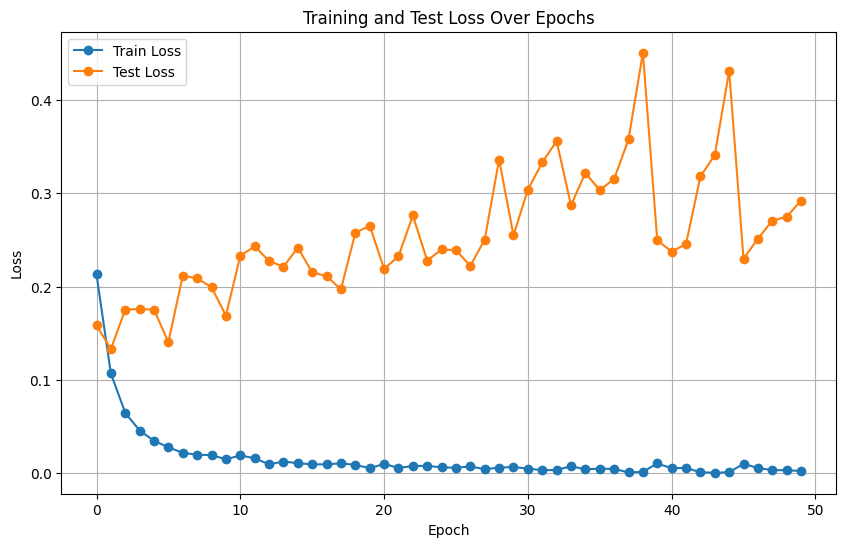

In [ ]:
plot_loss(losses)

### the second training
- just train fc, layer4.

In [ ]:
classifier_A = models.resnet18(pretrained=True)
for param in classifier_A.parameters():
    param.requires_grad = False

for param in classifier_A.fc.parameters():
    param.requires_grad = True

for param in classifier_A.layer4.parameters():
    param.requires_grad = True

num_ftrs = classifier_A.fc.in_features
classifier_A.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_A = classifier_A.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
losses, test_losses = train_model(model=classifier_A,
                                   train_loader=train_loader,
                                   test_loader=test_loader,
                                    loss_fn=nn.CrossEntropyLoss(),
                                    optimizer=optim.Adam(classifier_A.parameters(), lr=0.001),
                                    num_epochs=20)

Epoch 1/20: 100%|██████████| 547/547 [00:05<00:00, 92.97batch/s, loss=0.0015]


Train Loss: 0.0200 | Test Loss: 0.2907


Epoch 2/20: 100%|██████████| 547/547 [00:05<00:00, 91.35batch/s, loss=0.1169]


Train Loss: 0.0214 | Test Loss: 0.2661


Epoch 3/20: 100%|██████████| 547/547 [00:06<00:00, 90.83batch/s, loss=0.1674]


Train Loss: 0.0136 | Test Loss: 0.3256


Epoch 4/20: 100%|██████████| 547/547 [00:06<00:00, 86.59batch/s, loss=0.0139]


Train Loss: 0.0148 | Test Loss: 0.2925


Epoch 5/20: 100%|██████████| 547/547 [00:06<00:00, 90.96batch/s, loss=0.0077]


Train Loss: 0.0119 | Test Loss: 0.4571


Epoch 6/20: 100%|██████████| 547/547 [00:06<00:00, 84.54batch/s, loss=0.0088]


Train Loss: 0.0134 | Test Loss: 0.3599


Epoch 7/20: 100%|██████████| 547/547 [00:06<00:00, 90.90batch/s, loss=0.0003]


Train Loss: 0.0090 | Test Loss: 0.2973


Epoch 8/20: 100%|██████████| 547/547 [00:05<00:00, 92.80batch/s, loss=0.0032]


Train Loss: 0.0083 | Test Loss: 0.2921


Epoch 9/20: 100%|██████████| 547/547 [00:06<00:00, 90.75batch/s, loss=0.0146]


Train Loss: 0.0104 | Test Loss: 0.3368


Epoch 10/20: 100%|██████████| 547/547 [00:05<00:00, 93.23batch/s, loss=0.0002]


Train Loss: 0.0105 | Test Loss: 0.2894


Epoch 11/20: 100%|██████████| 547/547 [00:05<00:00, 92.53batch/s, loss=0.0009]


Train Loss: 0.0083 | Test Loss: 0.3536


Epoch 12/20: 100%|██████████| 547/547 [00:05<00:00, 91.59batch/s, loss=0.0293]


Train Loss: 0.0102 | Test Loss: 0.3238


Epoch 13/20: 100%|██████████| 547/547 [00:05<00:00, 94.07batch/s, loss=0.0008]


Train Loss: 0.0074 | Test Loss: 0.3340


Epoch 14/20: 100%|██████████| 547/547 [00:05<00:00, 91.32batch/s, loss=0.0176]


Train Loss: 0.0060 | Test Loss: 0.3101


Epoch 15/20: 100%|██████████| 547/547 [00:05<00:00, 93.71batch/s, loss=0.0079]


Train Loss: 0.0080 | Test Loss: 0.3393


Epoch 16/20: 100%|██████████| 547/547 [00:05<00:00, 93.44batch/s, loss=0.0070]


Train Loss: 0.0058 | Test Loss: 0.2977


Epoch 17/20: 100%|██████████| 547/547 [00:05<00:00, 92.76batch/s, loss=0.0001]


Train Loss: 0.0066 | Test Loss: 0.3829


Epoch 18/20: 100%|██████████| 547/547 [00:05<00:00, 94.05batch/s, loss=0.0000]


Train Loss: 0.0074 | Test Loss: 0.4311


Epoch 19/20: 100%|██████████| 547/547 [00:05<00:00, 91.42batch/s, loss=0.0000]


Train Loss: 0.0069 | Test Loss: 0.3541


Epoch 20/20: 100%|██████████| 547/547 [00:05<00:00, 93.67batch/s, loss=0.0000]


Train Loss: 0.0072 | Test Loss: 0.3184


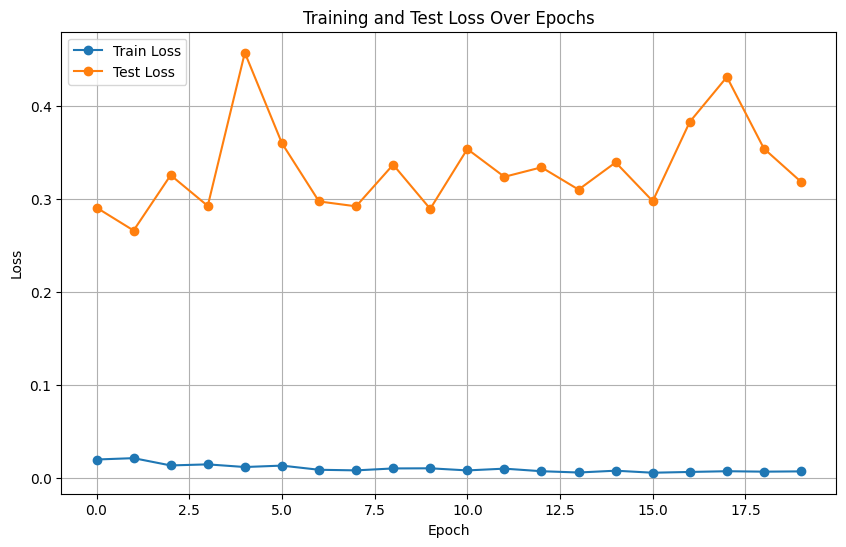

In [ ]:
plot_loss(losses, test_losses)

In [ ]:

def test_model(model, test_loader):
    model.eval()


    all_preds = []
    all_labels = []
    loss_test = 0.0
    running_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()


    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    return all_preds, all_labels


In [ ]:
pred_res, labels_res = test_model(classifier_A, test_loader)

100%|██████████| 235/235 [00:01<00:00, 158.08it/s]


In [ ]:
def evaluate_classifier(predictions: np.ndarray, labels: np.ndarray):
    """
    Evaluate a binary classifier.

    Parameters:
        predictions (np.ndarray): Predicted labels (0 or 1).
        labels (np.ndarray): True labels (0 or 1).

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)

    # For AUC, we need probability estimates (assuming binary classification)
    # If predictions are not probabilities, we can set them as dummy values
    # Here, we assume the predictions are 0 and 1, you need to adjust according to your model's output.
    if np.unique(predictions).size == 2:  # Only if we have both classes
        # Dummy probability scores for AUC calculation (assumed 0.5 for incorrect predictions)
        dummy_probabilities = np.where(predictions == 1, 0.9, 0.1)  # You may adjust this
        auc = roc_auc_score(labels, dummy_probabilities)
    else:
        auc = None  # Cannot compute AUC if there's only one class in predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)

    # Print classification report
    print(classification_report(labels, predictions))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'confusion_matrix': cm
    }

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3752
           1       0.93      0.94      0.93      3748

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



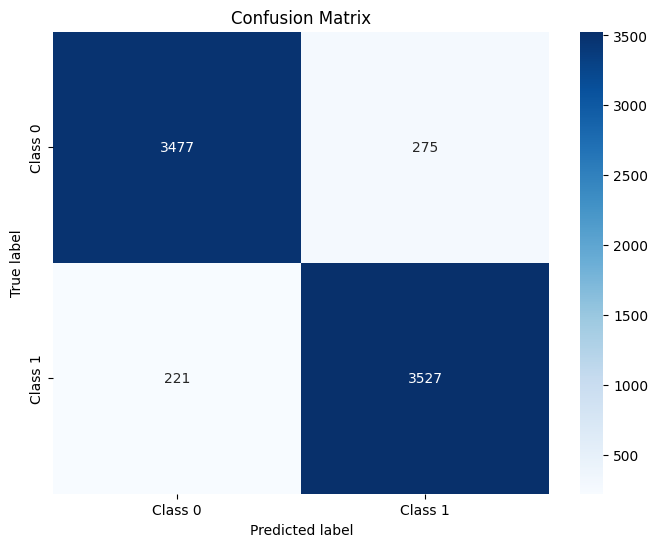

{'accuracy': 0.9338666666666666,
 'f1_score': 0.9343046357615894,
 'precision': 0.927669647553919,
 'recall': 0.9410352187833512,
 'auc': 0.9338704878564944,
 'confusion_matrix': array([[3477,  275],
        [ 221, 3527]])}

In [ ]:
evaluate_classifier(pred_res, labels_res)

### trying for better classifier A

In [ ]:
classifier_A = models.resnet18(pretrained=True)
for param in classifier_A.parameters():
    param.requires_grad = False

for param in classifier_A.fc.parameters():
    param.requires_grad = True

# train less layers
for i, layer in enumerate(classifier_A.layer4.parameters()):
    if i > 10:
        layer.requires_grad = True
    else:
        layer.requires_grad = False

num_ftrs = classifier_A.fc.in_features
classifier_A.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_A = classifier_A.to(device)

In [ ]:
losses, test_losses = train_model(model=classifier_A,
                                   train_loader=train_loader,
                                   test_loader=test_loader,
                                    loss_fn=nn.CrossEntropyLoss(),
                                    optimizer=optim.Adam(classifier_A.parameters(), lr=0.001),
                                    num_epochs=20)

Epoch 1/20: 100%|██████████| 547/547 [00:05<00:00, 104.55batch/s, loss=0.1992]


Train Loss: 0.2946 | Test Loss: 0.2404


Epoch 2/20: 100%|██████████| 547/547 [00:05<00:00, 103.26batch/s, loss=0.3541]


Train Loss: 0.2427 | Test Loss: 0.2302


Epoch 3/20: 100%|██████████| 547/547 [00:05<00:00, 104.44batch/s, loss=0.1449]


Train Loss: 0.2217 | Test Loss: 0.2335


Epoch 4/20: 100%|██████████| 547/547 [00:05<00:00, 101.80batch/s, loss=0.3572]


Train Loss: 0.2005 | Test Loss: 0.2640


Epoch 5/20: 100%|██████████| 547/547 [00:05<00:00, 104.41batch/s, loss=0.3426]


Train Loss: 0.1743 | Test Loss: 0.2546


Epoch 6/20: 100%|██████████| 547/547 [00:05<00:00, 101.83batch/s, loss=0.1436]


Train Loss: 0.1648 | Test Loss: 0.2920


Epoch 7/20: 100%|██████████| 547/547 [00:05<00:00, 104.90batch/s, loss=0.4505]


Train Loss: 0.1375 | Test Loss: 0.2569


Epoch 8/20: 100%|██████████| 547/547 [00:05<00:00, 102.25batch/s, loss=0.2644]


Train Loss: 0.1292 | Test Loss: 0.2475


Epoch 9/20: 100%|██████████| 547/547 [00:05<00:00, 102.87batch/s, loss=0.1811]


Train Loss: 0.1062 | Test Loss: 0.2806


Epoch 10/20: 100%|██████████| 547/547 [00:05<00:00, 105.08batch/s, loss=0.0719]


Train Loss: 0.0946 | Test Loss: 0.2890


Epoch 11/20: 100%|██████████| 547/547 [00:05<00:00, 101.88batch/s, loss=0.0383]


Train Loss: 0.0818 | Test Loss: 0.3251


Epoch 12/20: 100%|██████████| 547/547 [00:05<00:00, 105.53batch/s, loss=0.1269]


Train Loss: 0.0787 | Test Loss: 0.3274


Epoch 13/20: 100%|██████████| 547/547 [00:05<00:00, 101.78batch/s, loss=0.0926]


Train Loss: 0.0689 | Test Loss: 0.3528


Epoch 14/20: 100%|██████████| 547/547 [00:05<00:00, 104.63batch/s, loss=0.0636]


Train Loss: 0.0629 | Test Loss: 0.3257


Epoch 15/20: 100%|██████████| 547/547 [00:05<00:00, 103.01batch/s, loss=0.0408]


Train Loss: 0.0535 | Test Loss: 0.3620


Epoch 16/20: 100%|██████████| 547/547 [00:05<00:00, 103.26batch/s, loss=0.0107]


Train Loss: 0.0582 | Test Loss: 0.3468


Epoch 17/20: 100%|██████████| 547/547 [00:05<00:00, 102.00batch/s, loss=0.0647]


Train Loss: 0.0507 | Test Loss: 0.3735


Epoch 18/20: 100%|██████████| 547/547 [00:05<00:00, 104.75batch/s, loss=0.0253]


Train Loss: 0.0454 | Test Loss: 0.3540


Epoch 19/20: 100%|██████████| 547/547 [00:05<00:00, 103.82batch/s, loss=0.2159]


Train Loss: 0.0430 | Test Loss: 0.3525


Epoch 20/20: 100%|██████████| 547/547 [00:05<00:00, 103.39batch/s, loss=0.0390]


Train Loss: 0.0393 | Test Loss: 0.3578


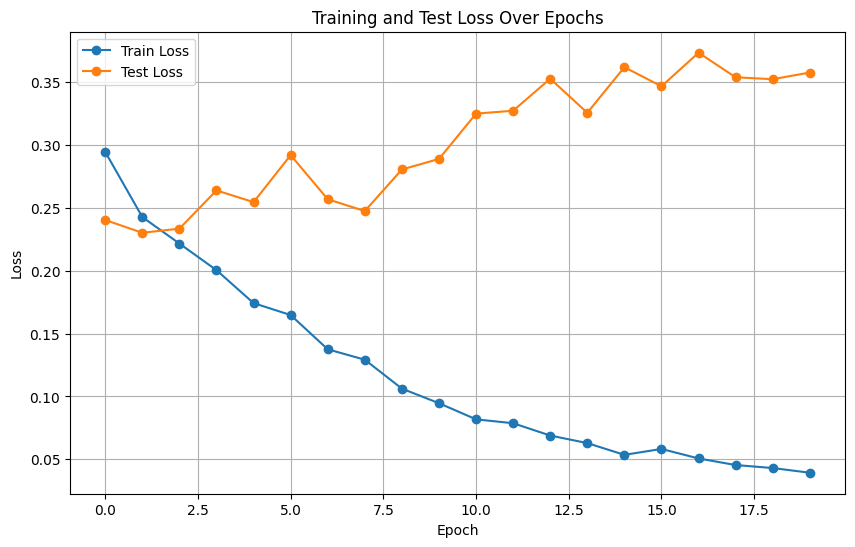

In [ ]:
plot_loss(losses, test_losses)

#### try again
- using different batch size

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
classifier_A = models.resnet18(pretrained=True)
for param in classifier_A.parameters():
    param.requires_grad = False

for param in classifier_A.fc.parameters():
    param.requires_grad = True

# train less layers
for layer in classifier_A.layer4.parameters():
    layer.requires_grad = True

for layer in classifier_A.layer3.parameters():
    layer.requires_grad = True

num_ftrs = classifier_A.fc.in_features
classifier_A.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_A = classifier_A.to(device)

In [ ]:
losses, test_losses = train_model(model=classifier_A,
                                   train_loader=train_loader,
                                   test_loader=test_loader,
                                    loss_fn=nn.CrossEntropyLoss(),
                                    optimizer=optim.Adam(classifier_A.parameters(), lr=0.0005),
                                    num_epochs=20)

Epoch 1/20: 100%|██████████| 137/137 [00:02<00:00, 48.93batch/s, loss=0.0905]


Train Loss: 0.1906 | Test Loss: 0.1300


Epoch 2/20: 100%|██████████| 137/137 [00:02<00:00, 49.11batch/s, loss=0.0748]


Train Loss: 0.0629 | Test Loss: 0.2119


Epoch 3/20: 100%|██████████| 137/137 [00:02<00:00, 49.98batch/s, loss=0.0352]


Train Loss: 0.0380 | Test Loss: 0.2061


Epoch 4/20: 100%|██████████| 137/137 [00:02<00:00, 48.63batch/s, loss=0.0235]


Train Loss: 0.0288 | Test Loss: 0.2095


Epoch 5/20: 100%|██████████| 137/137 [00:02<00:00, 49.55batch/s, loss=0.0024]


Train Loss: 0.0178 | Test Loss: 0.2322


Epoch 6/20: 100%|██████████| 137/137 [00:02<00:00, 50.07batch/s, loss=0.0341]


Train Loss: 0.0182 | Test Loss: 0.1912


Epoch 7/20: 100%|██████████| 137/137 [00:02<00:00, 49.22batch/s, loss=0.0035]


Train Loss: 0.0178 | Test Loss: 0.1792


Epoch 8/20: 100%|██████████| 137/137 [00:02<00:00, 49.78batch/s, loss=0.0022]


Train Loss: 0.0137 | Test Loss: 0.2059


Epoch 9/20: 100%|██████████| 137/137 [00:02<00:00, 49.90batch/s, loss=0.0045]


Train Loss: 0.0104 | Test Loss: 0.2212


Epoch 10/20: 100%|██████████| 137/137 [00:02<00:00, 49.32batch/s, loss=0.0047]


Train Loss: 0.0082 | Test Loss: 0.2115


Epoch 11/20: 100%|██████████| 137/137 [00:02<00:00, 49.22batch/s, loss=0.0013]


Train Loss: 0.0110 | Test Loss: 0.2032


Epoch 12/20: 100%|██████████| 137/137 [00:02<00:00, 49.76batch/s, loss=0.0054]


Train Loss: 0.0077 | Test Loss: 0.2298


Epoch 13/20: 100%|██████████| 137/137 [00:02<00:00, 49.53batch/s, loss=0.0120]


Train Loss: 0.0109 | Test Loss: 0.2094


Epoch 14/20: 100%|██████████| 137/137 [00:02<00:00, 47.89batch/s, loss=0.0004]


Train Loss: 0.0079 | Test Loss: 0.2421


Epoch 15/20: 100%|██████████| 137/137 [00:02<00:00, 49.25batch/s, loss=0.0085]


Train Loss: 0.0080 | Test Loss: 0.1994


Epoch 16/20: 100%|██████████| 137/137 [00:02<00:00, 49.90batch/s, loss=0.0047]


Train Loss: 0.0102 | Test Loss: 0.2424


Epoch 17/20: 100%|██████████| 137/137 [00:02<00:00, 49.15batch/s, loss=0.0019]


Train Loss: 0.0084 | Test Loss: 0.2211


Epoch 18/20: 100%|██████████| 137/137 [00:02<00:00, 49.36batch/s, loss=0.0001]


Train Loss: 0.0043 | Test Loss: 0.2373


Epoch 19/20: 100%|██████████| 137/137 [00:02<00:00, 50.45batch/s, loss=0.0424]


Train Loss: 0.0061 | Test Loss: 0.2331


Epoch 20/20: 100%|██████████| 137/137 [00:02<00:00, 49.13batch/s, loss=0.0155]


Train Loss: 0.0098 | Test Loss: 0.2043


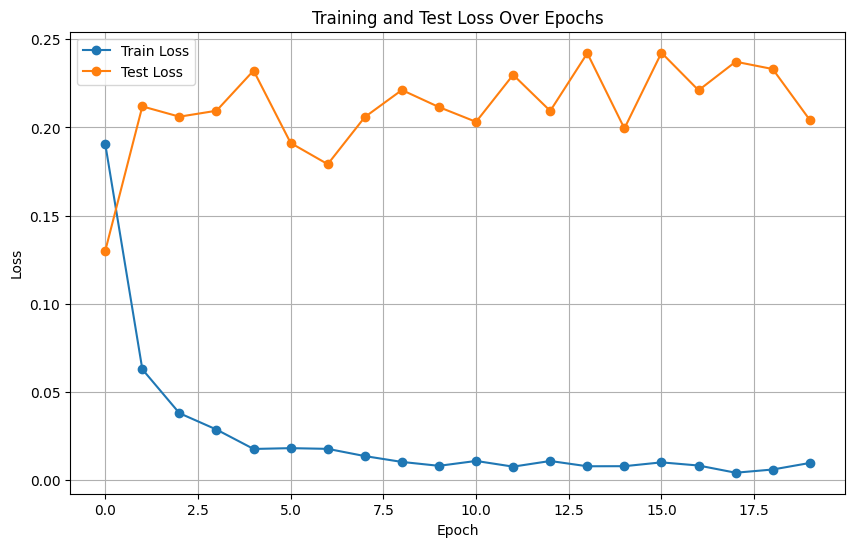

In [ ]:
plot_loss(losses, test_losses)

100%|██████████| 59/59 [00:00<00:00, 65.57it/s]


              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3752
           1       0.96      0.93      0.95      3748

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



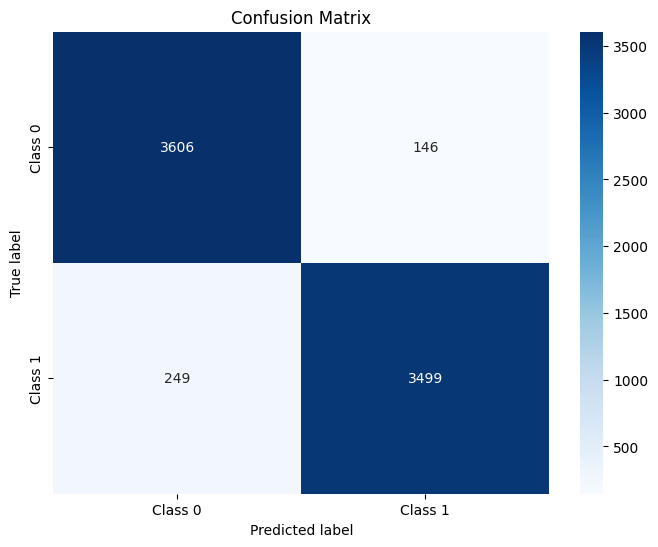

{'accuracy': 0.9473333333333334,
 'f1_score': 0.9465710807520628,
 'precision': 0.9599451303155007,
 'recall': 0.933564567769477,
 'auc': 0.9473259939060605,
 'confusion_matrix': array([[3606,  146],
        [ 249, 3499]])}

In [ ]:
pred_res, labels_res = test_model(classifier_A, test_loader)
evaluate_classifier(pred_res, labels_res)

### demonstrate misclassification result

In [208]:


def plot_images_with_labels(images, pred_labels, true_labels, figsize=(12, 12)):

    temp_s = 0
    indices = []
    for i in range(len(pred_labels)):
        if pred_labels[i] != true_labels[i]:
            indices.append(i)
            temp_s += 1
        if temp_s > 7:
            break

    num_images = len(indices)
    rows = 2
    cols = (num_images // rows) + (num_images % rows > 0)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        img = test_dataset[idx][0].permute(1, 2, 0).numpy()
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        elif img.dtype == np.int32 or img.dtype == np.int64:
            img = np.clip(img, 0, 255).astype(np.uint8)
        ax.imshow(img)
        ax.axis('off')

        title = f"True: {label_str[true_labels[idx]]}\nPred: {label_str[pred_labels[idx]]}"
        ax.set_title(title, color=("green" if true_labels[idx] == pred_labels[idx] else "red"))


    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


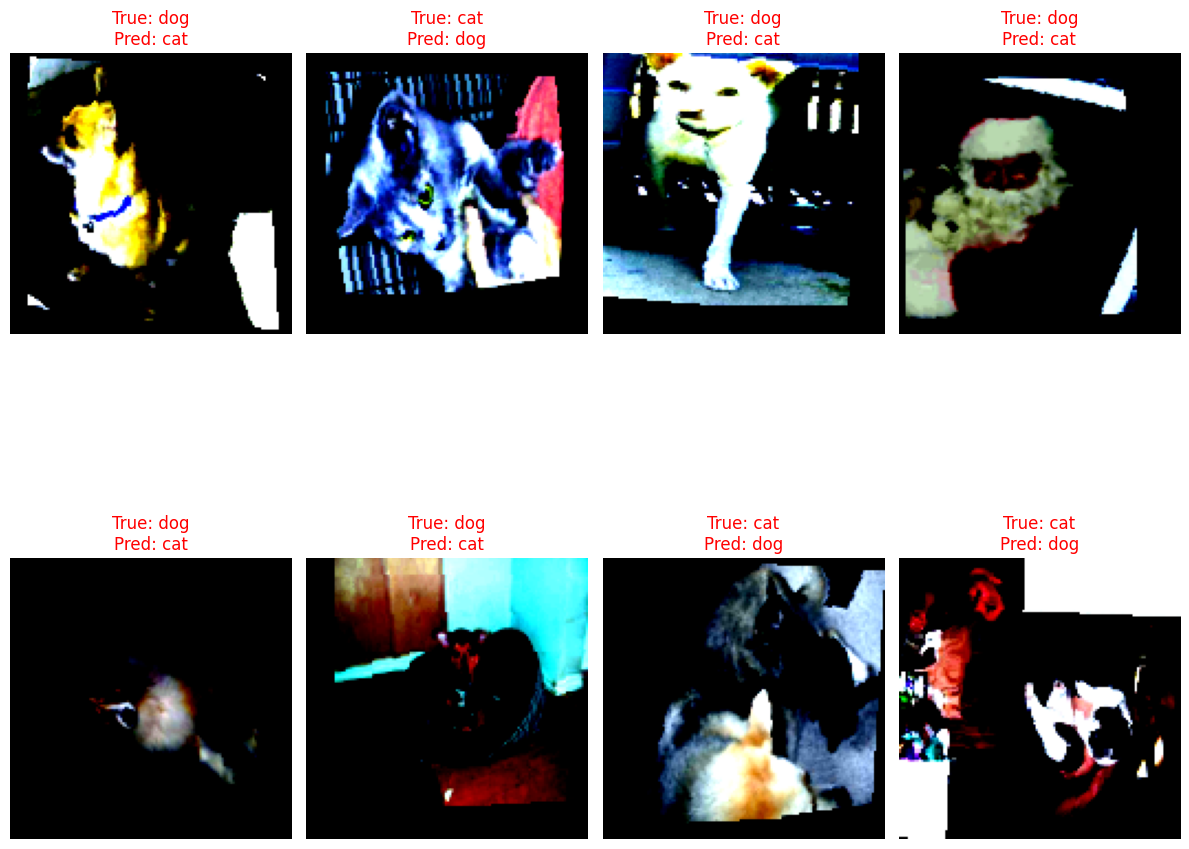

In [209]:
plot_images_with_labels(test_dataset, pred_res, labels_res)